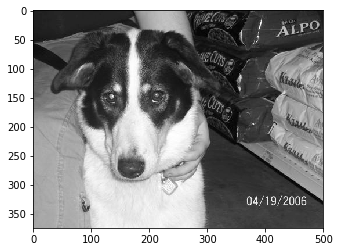

In [2]:
#IMPORT DES DEPENDANCES

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/code/2.Images/Animaux"

CATEGORIES = ["Dog", "Cat"] # créer 2 catégories

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  # créer un chemin vers les chiens et les chats 
    for img in os.listdir(path):  # itérer sur chaque image par chiens et chats (envion 25 000) 
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
        plt.imshow(img_array, cmap='gray')  # passage en noir et blanc
        plt.show()  # affichage!

        break  # nous en voulons juste une imgae pour le moment, alors pause 
    break 


In [2]:
print(img_array)

[[ 93 103  97 ... 133 127 113]
 [ 93  94  95 ... 114 115 114]
 [102 100 102 ...  76  87  96]
 ...
 [152 150 148 ... 246 246 247]
 [146 147 150 ... 246 246 247]
 [140 143 146 ... 246 246 247]]


In [3]:
print(img_array.shape) # c est une image de 500 de hauteur et 470 de large 
# il y a 3 canaux a cause de la couleur (RGV) 


(500, 470)


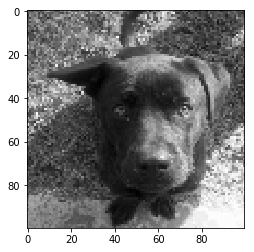

In [4]:
IMG_SIZE = 100 # nous mettons toutes des images à la meme taille 100)

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()


In [5]:
# CREATION DES DONNEES D ENTRAINEMENT 

 
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # créer un chemin vers les chiens et les chats 
        class_num = CATEGORIES.index(category)  # obtenir la classification (0 ou 1). 0 = chien 1 = chat

        for img in tqdm(os.listdir(path)):  # itérer sur chaque image par chiens et chats 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # redimentionner pour normaliser la taille des données
                training_data.append([new_array, class_num])  # ajoutez ceci à notre formation_data 
            except Exception as e:  # idans l'intérêt de garder la sortie propre ... 
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 12485/12485 [01:59<00:00, 104.39it/s]24915



In [6]:
import random

random.shuffle(training_data) # melange des donnees 

In [7]:
for sample in training_data[:10]:
    print(sample[1]) # test pour voir si les images ont bien été melangees

0
0
1
0
0
0
1
1
0
1


In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[ 47]
   [109]
   [100]
   ...
   [112]
   [111]
   [ 85]]

  [[ 63]
   [112]
   [105]
   ...
   [109]
   [109]
   [ 78]]

  [[ 81]
   [106]
   [103]
   ...
   [110]
   [111]
   [ 75]]

  ...

  [[ 47]
   [ 39]
   [ 35]
   ...
   [105]
   [110]
   [114]]

  [[ 46]
   [ 41]
   [ 39]
   ...
   [117]
   [115]
   [108]]

  [[ 44]
   [ 44]
   [ 41]
   ...
   [112]
   [114]
   [115]]]]


In [9]:
# SAUVEGARDE DES DONNEES 

# on les sauvegarde pour ne pas avoir à les calculer à chaque tour du modèle 

import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()



In [10]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
#from tensorflow.keras.callbacks import TensorBoard
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=3,
                      validation_split=0.3,
                      callbacks=[tensorboard])

model.save('/code/3.Modeles/modelchiensetchats.model')

MemoryError: Unable to allocate 1.86 GiB for an array with shape (24915, 100, 100, 1) and data type float64